In [10]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import scipy as sp

# I. US Kidney Recipient Candidates

## Characterizing the distribution

In [71]:
included_rows = [
    0, # WL_ORG - Organ type
    54, # INIT_AGE - Initial age of recipient at listing
    61, # INIT_DATE - Initial date of recipient listing
    24, # GENDER - Recipient gender
    63, # ETHCAT - Recipient ethnicity
    385, # HGT_CM_CALC - Recipient height (cm)
    386, # WGT_KG_CALC - Recipient weight (kg)
    33, # EDUCATION - Recipient highest education at listing
    32, # PERM_STATE - Recipient state of residency
    103, # PRI_PAYMENT_TCR_KI - Recipient primary projected payment source at listing
    6, # CREAT_CLEAR - Recipient CrCl at listing
    7, # GFR - Recipient GFR at listing
    37, # DIAB - Recipient diabetes at listing
    8, # DONATION - Receives allocation points for previously donating an organ
    2, # NUM_PREV_TX - Recipient number of previous transplants
    47, # INIT_CPRA - Recipient CPRA at listing
    48, # END_CPRA - Recipient most recent CPRA
    58, # DIALYSIS_DATE - Date recipient started regular dialysis for ESRD
    118, # TX_DATE - Transplant date
    68, # COMPOSITE_DEATH_DATE - Death date
    67, # DAYSWAIT_ALLOC - official waiting time for allocation priority as measured by the OPTN standards
    194, # DON_TY - Decreased or living donor
]
kidpan_data = pd.read_csv(
    "C:/Users/brand/Desktop/STAR_Delimited/Delimited Text File 202312/Kidney_ Pancreas_ Kidney-Pancreas/KIDPAN_DATA.DAT",
    sep="\t",
    usecols=included_rows
)
colnames = pd.read_csv(
    "C:/Users/brand/Desktop/STAR_Delimited/Analysis/KIDPAN_DATA_colnames.csv",
    sep=",",
    header=0,
    skiprows=lambda x : x-1 not in included_rows + [-1]
)
kidpan_data.columns = list(colnames["LABEL"])
kidpan_data = kidpan_data[kidpan_data["WL_ORG"] == "KI"]
kidpan_data = kidpan_data[kidpan_data["DON_TY"] != "F"]

C:\Users\brand\AppData\Local\Temp\ipykernel_15028\1679118887.py:25: DtypeWarning: Columns (2,8,33,37,47,48,54,67,103,194,385,386) have mixed types. Specify dtype option on import or set low_memory=False.
  kidpan_data = pd.read_csv(


In [73]:
kidpan_data = kidpan_data.replace(".", np.nan)

for numeric_column in ["INIT_AGE", "HGT_CM_CALC", "WGT_KG_CALC", "CREAT_CLEAR", "GFR", "NUM_PREV_TX", "INIT_CPRA", "END_CPRA", "DAYSWAIT_ALLOC"]:
    kidpan_data[numeric_column] = kidpan_data[numeric_column].astype(float)
for date_column in ["INIT_DATE", "DIALYSIS_DATE", "TX_DATE", "COMPOSITE_DEATH_DATE"]:
    kidpan_data[date_column] = pd.to_datetime(kidpan_data[date_column].replace(".", np.nan))

kidpan_data = kidpan_data.replace({
    "ETHCAT" : {
        1 : "White, Non-Hispanic",
        2 : "Black, Non-Hispanic",
        4 : "Hispanic/Latino",
        5 : "Asian, Non-Hispanic",
        6 : "Amer Ind/Alaska Native, Non-Hispanic",
        7 : "Native Hawaiian/other Pacific Islander, Non-Hispanic",
        9 : "Multiracial, Non-Hispanic",
        998 : np.nan,
    },
    "EDUCATION" : {
        1 : "None",
        2 : "Grade School (0-8)",
        3 : "High School (9-12) or GED",
        4 : "Attended College/Technical School",
        5 : "Associate/Bachelor Degree",
        6 : "Post-College Graduate Degree",
        996 : np.nan,
        998 : np.nan,
    },
    "PRI_PAYMENT_TCR_KI" : {
        1 : "Private insurance",
        2 : "Public insurance - Medicaid",
        3 : "Public insurance - Medicare FFS (Fee for Service)",
        4 : "Public insurance - Medicare & Choice",
        5 : "Public insurance - CHIP (Children's Health Insurance Program)",
        6 : "Public insurance - Department of VA",
        7 : "Public insurance - Other government",
        8 : "Self",
        9 : "Donation",
        10 : "Free Care",
        11 : "Pending",
        12 : "Foreign Government Specify",
        13 : "Public insurance - Medicare (further detail not collected)",
        14 : "US/State Govt Agency",
        15 : np.nan
    },
    "DIABTY" : {
        1 : "No",
        2 : "Type I",
        3 : "Type II",
        4 : "Other",
        5 : np.nan,
        998 : np.nan,
    }
})
kidpan_data["PERM_STATE"] = kidpan_data["PERM_STATE"].replace("ZZ", np.nan)
kidpan_data["DONATION"] = (kidpan_data["DONATION"] == "Y")

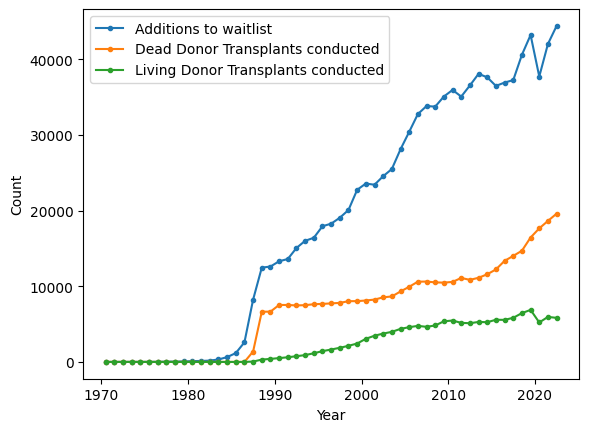

In [79]:
kidpan_data["INIT_DATE_YEARS_SINCE_1970"] = (kidpan_data["INIT_DATE"] - pd.Timestamp(year=1970, month=1, day=1)).dt.days / 365
kidpan_data["IS_WHITE"] = (kidpan_data["ETHCAT"] == "White, Non-Hispanic")
kidpan_data["IS_MALE"] = (kidpan_data["GENDER"] == "M")
kidpan_data["ATTENDED_COLLEGE"] = ((kidpan_data["EDUCATION"] == "Attended College/Technical School") | (kidpan_data["EDUCATION"] == "Associate/Bachelor Degree") | (kidpan_data["EDUCATION"] == "Post-College Graduate Degree"))

# Group by 'years_since_first' with bin size 1 and calculate mean of 'INIT_AGE'
year_groupings = kidpan_data.groupby(
    pd.cut(
        kidpan_data['INIT_DATE_YEARS_SINCE_1970'],
        bins=np.arange(kidpan_data['INIT_DATE_YEARS_SINCE_1970'].min(), kidpan_data['INIT_DATE_YEARS_SINCE_1970'].max() + 1, 1)
    ),
    dropna=True
)
yearly_means = year_groupings.mean(numeric_only=True)
yearly_stes = year_groupings.sem(numeric_only=True)

# Create plot of annual waitlist additions
n_wait,x_wait,_ = plt.hist(kidpan_data["INIT_DATE_YEARS_SINCE_1970"] + 1970, bins=np.arange(1970,2023+1,1))
bin_centers_wait = 0.5*(x_wait[1:]+x_wait[:-1])
# Create plot of annual transplants conducted
kidpan_data["TX_DATE_YEARS_SINCE_1970"] = (kidpan_data["TX_DATE"] - pd.Timestamp(year=1970, month=1, day=1)).dt.days / 365
n_trans_dd,x_trans_dd,_ = plt.hist(kidpan_data["TX_DATE_YEARS_SINCE_1970"][kidpan_data["DON_TY"] == "C"] + 1970, bins=np.arange(1970,2023+1,1))
bin_centers_trans_dd = 0.5*(x_trans_dd[1:]+x_trans_dd[:-1])
n_trans_ld,x_trans_ld,_ = plt.hist(kidpan_data["TX_DATE_YEARS_SINCE_1970"][kidpan_data["DON_TY"] == "L"] + 1970, bins=np.arange(1970,2023+1,1))
bin_centers_trans_ld = 0.5*(x_trans_ld[1:]+x_trans_ld[:-1])
# Output plots together
plt.close()
plt.plot(bin_centers_wait,n_wait, marker=".", label="Additions to waitlist")
plt.plot(bin_centers_trans_dd,n_trans_dd, marker=".", label="Dead Donor Transplants conducted")
plt.plot(bin_centers_trans_ld,n_trans_ld, marker=".", label="Living Donor Transplants conducted")
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

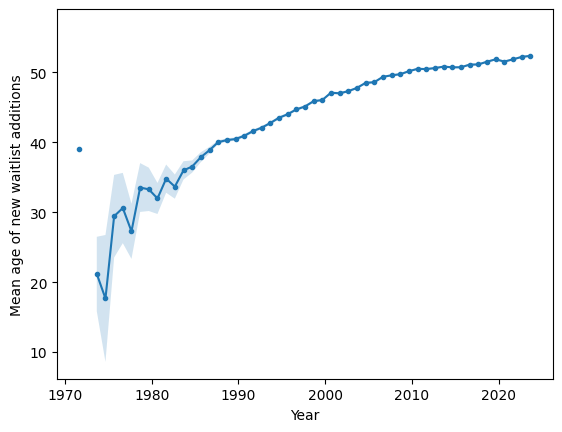

In [80]:
# Plotting annual age means
plt.plot(yearly_means.index.categories.mid + 1970, yearly_means["INIT_AGE"], marker='.', linestyle='-')
plt.fill_between(
    yearly_means.index.categories.mid + 1970,
    yearly_means['INIT_AGE'] - yearly_stes['INIT_AGE']*1.96,
    yearly_means['INIT_AGE'] + yearly_stes['INIT_AGE']*1.96,
    alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Mean age of new waitlist additions')
plt.show()

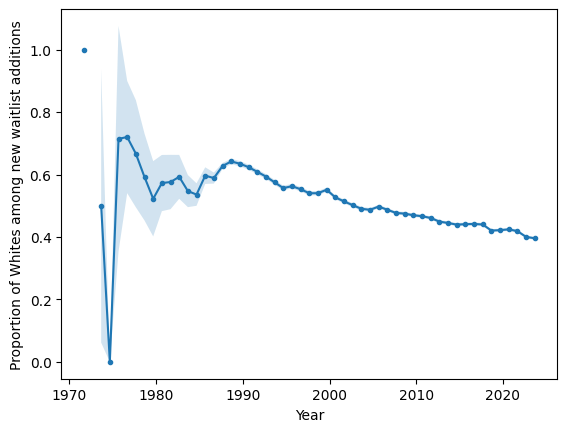

In [39]:
# Plotting annual age means
plt.plot(yearly_means.index.categories.mid + 1970, yearly_means['IS_WHITE'], marker='.', linestyle='-')
plt.fill_between(
    yearly_means.index.categories.mid + 1970,
    yearly_means['IS_WHITE'] - yearly_stes['IS_WHITE']*1.96,
    yearly_means['IS_WHITE'] + yearly_stes['IS_WHITE']*1.96,
    alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Proportion of Whites among new waitlist additions')
plt.show()

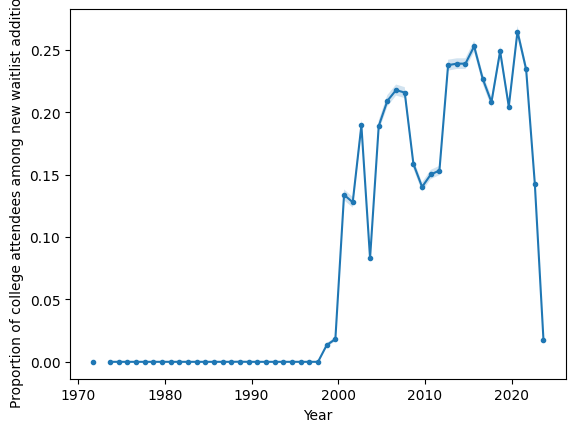

In [44]:
# Plotting annual age means
plt.plot(yearly_means.index.categories.mid + 1970, yearly_means['ATTENDED_COLLEGE'], marker='.', linestyle='-')
plt.fill_between(
    yearly_means.index.categories.mid + 1970,
    yearly_means['ATTENDED_COLLEGE'] - yearly_stes['ATTENDED_COLLEGE']*1.96,
    yearly_means['ATTENDED_COLLEGE'] + yearly_stes['ATTENDED_COLLEGE']*1.96,
    alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Proportion of college attendees among new waitlist additions')
plt.show()

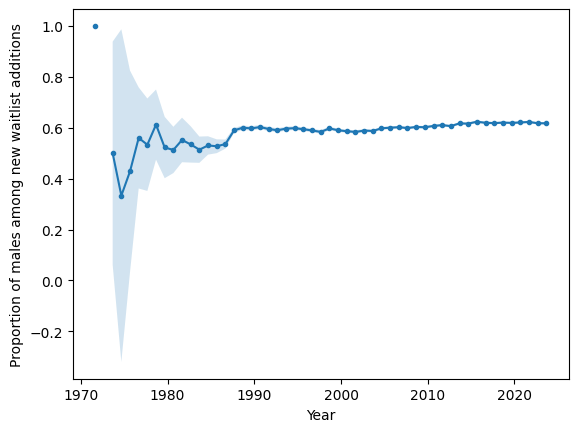

In [51]:
# Plotting annual age means
plt.plot(yearly_means.index.categories.mid + 1970, yearly_means['IS_MALE'], marker='.', linestyle='-')
plt.fill_between(
    yearly_means.index.categories.mid + 1970,
    yearly_means['IS_MALE'] - yearly_stes['IS_MALE']*1.96,
    yearly_means['IS_MALE'] + yearly_stes['IS_MALE']*1.96,
    alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Proportion of males among new waitlist additions')
plt.show()

We ultimately choose to restrict our population pool to the last 10 years; that is, 2013-2023 (inclusive).

In [81]:
kidpan_data = kidpan_data[kidpan_data["INIT_DATE"].dt.year >= 2013]

## Mortality, Income, and Costs Modeling
### Mortality Rates
We model mortality rates according to the "Gompertz–Makeham Law of Mortality," which models human mortality as the sum of an age-dependent component, which increases exponentially with age, and an age-independent component. The hazard function (that is, the mortality rate function over age) of the Gompertz-Makeham distribution is modeled as $\alpha e^{\beta t} + \gamma$, where $t$ is a person's age.

In [84]:
class gompertz_makeham(sp.stats.rv_continuous):
    def _pdf(self, x, alpha, beta, gamma):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        return (alpha * np.exp(beta * x) + gamma) * np.exp(-gamma * x - alpha/beta * (np.exp(beta * x) - 1))
    def _cdf(self, x, alpha, beta, gamma):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        return 1 - np.exp(-gamma * x - alpha/beta * (np.exp(beta * x) - 1))

We can use existing research on the mortality rates of patients both on dialsyis and who receive transplants to estimate the parameters for the Gompertz-Makeham distribution based on a given person's age, gender, and race. An [analysis](<https://journals.lww.com/cjasn/fulltext/2013/06000/the_relationship_of_age,_race,_and_ethnicity_with.11.aspx>) of 1.2 million dialysis patients ages 18 or older between 1995 and 2009 found the following annual mortality rates over age for (non-Hispanic) Whites, (non-Hispanic) Blacks, and Hispanics:

In [83]:
mortality_rate_dialysis_table = pd.DataFrame(data={
    "Age bin lower bound" : [18, 31, 41, 51, 61, 71, 80],
    "Age bin upper bound" : [30, 40, 50, 60, 70, 80, 100],
    "White count" : [40582, 84089, 176384, 302268, 418774, 438613, 161505],
    "White mortality (%)" : [6.9, 11.5, 15.5, 21.2, 29.4, 39.9, 56.7],
    "Black count" : [70994, 146611, 251712, 301372, 272866, 160121, 41636],
    "Black mortality (%)" : [7.1, 9.4, 11.9, 15.2, 21.2, 31.3, 48.6],
    "Hispanic count" : [29543, 40150, 77555, 120868, 120788, 68341, 15918],
    "Hispanic mortality (%)" : [3.3, 6.8, 10, 14.2, 20.8, 31.3, 49.7]
})
mortality_rate_dialysis_table

,Age bin lower bound,Age bin upper bound,White count,White mortality (%),Black count,Black mortality (%),Hispanic count,Hispanic mortality (%)
0,18,30,40582,6.9,70994,7.1,29543,3.3
1,31,40,84089,11.5,146611,9.4,40150,6.8
2,41,50,176384,15.5,251712,11.9,77555,10.0
3,51,60,302268,21.2,301372,15.2,120868,14.2
4,61,70,418774,29.4,272866,21.2,120788,20.8
5,71,80,438613,39.9,160121,31.3,68341,31.3
6,80,100,161505,56.7,41636,48.6,15918,49.7


We fit this data to our Gompertz-Makeham model for each race category:

In [ ]:
for race in ["White", "Black", "Hispanic"]:
    plt.hist(mortality_rate_dialysis_table[""])
plt.show()